#**Sentiment analysis on Twitter data - CIS 520**



# Import packages

In [1]:
! pip install ktrain
!pip install fasttext

     |████████████████████████████████| 25.3MB 8.6MB/s 
     |████████████████████████████████| 6.8MB 38.3MB/s 
     |████████████████████████████████| 983kB 40.8MB/s 
     |████████████████████████████████| 266kB 40.0MB/s 
     |████████████████████████████████| 1.3MB 30.7MB/s 
     |████████████████████████████████| 1.2MB 38.4MB/s 
     |████████████████████████████████| 471kB 36.3MB/s 
     |████████████████████████████████| 890kB 30.4MB/s 
     |████████████████████████████████| 2.9MB 36.0MB/s 
  Created wheel for ktrain: filename=ktrain-0.25.3-cp36-none-any.whl size=25276312 sha256=6a150e92d6fc19ea205a566cd6fdb2b63398ca4d41c806b0a088da72d37e8316
  Stored in directory: /root/.cache/pip/wheels/86/cd/9c/ad53b98a3eccf4ddeddccfce99d353781f206a1ac4287ca721
  Created wheel for langdetect: filename=langdetect-1.0.8-cp36-none-any.whl size=993194 sha256=0bb88bc3bb622b6b87d10722293d7dfc3da2e546834dd2b35fc6d77b2ba368c8
  Stored in directory: /root/.cache/pip/wheels/8d/b3/aa/6d99de9f3841d7d3d4

In [2]:
# First prepare Python packages and Kaggle Dataset
import numpy as np
import pandas as pd
import seaborn as sns
import string
import sklearn as skl
import sklearn 
from collections import Counter
import matplotlib.pyplot as plt
from google.colab import files
from gensim.test.utils import common_texts
from gensim.models import Word2Vec
import gensim.downloader as api
import re
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud

import ktrain
from ktrain import text
from sklearn.naive_bayes import MultinomialNB
import re
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from tqdm import tqdm

# Connect with Kaggle API

Navigate to https://www.kaggle.com. Then go to the [Account tab of your user profile](https://www.kaggle.com/me/account) and select Create API Token. This will trigger the download of kaggle.json, a file containing your API credentials.

Then run the cell below to upload kaggle.json to your Colab runtime.

In [3]:
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 69 bytes


In [4]:
!kaggle competitions download -c tweet-sentiment-extraction
!unzip train.csv.zip

  0% 0.00/41.4k [00:00<?, ?B/s]
100% 41.4k/41.4k [00:00<00:00, 16.3MB/s]
  0% 0.00/1.23M [00:00<?, ?B/s]
100% 1.23M/1.23M [00:00<00:00, 81.8MB/s]
  0% 0.00/307k [00:00<?, ?B/s]
100% 307k/307k [00:00<00:00, 97.1MB/s]
Archive:  train.csv.zip
  inflating: train.csv               


# EDA

In [5]:
train_data = pd.read_csv('/content/train.csv')
test_data = pd.read_csv('/content/test.csv')
train_data.dropna(inplace = True)
test_data.dropna(inplace=True)

In [6]:
# train dataset
train_data.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [7]:
# test dataset
test_data.head()

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


## 1. Distribution of sentiments in train and test dataset

In [8]:
train_data.groupby('sentiment').count()['text'].reset_index().sort_values(by='text',ascending=False)

,sentiment,text
1,neutral,11117
2,positive,8582
0,negative,7781


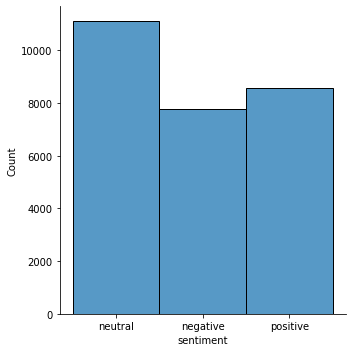

In [9]:
sns.displot(data=train_data,x='sentiment')
plt.show()

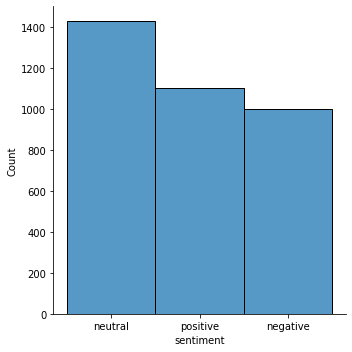

In [10]:
sns.displot(data=test_data,x='sentiment')
plt.show()

## Difference between the full text and the selected text

In [11]:
train_data['num_select_words'] = train_data['selected_text'].apply(lambda x :len(str(x).split()))
train_data['num_full_words'] = train_data['text'].apply(lambda x :len(str(x).split()))
train_data['diff_in_words'] = train_data['num_full_words'] - train_data['num_select_words']
train_data

,textID,text,selected_text,sentiment,num_select_words,num_full_words,diff_in_words
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,7,7,0
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,2,10,8
2,088c60f138,my boss is bullying me...,bullying me,negative,2,5,3
3,9642c003ef,what interview! leave me alone,leave me alone,negative,3,5,2
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,3,14,11
...,...,...,...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative,2,16,14
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative,3,23,20
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive,6,22,16
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive,6,6,0


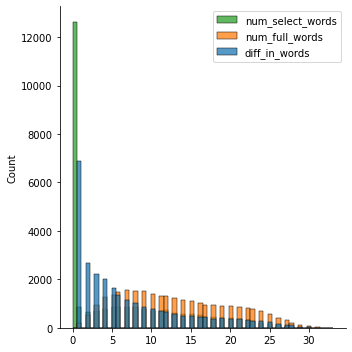

In [12]:
sns.displot(data=train_data, legend=False, )
plt.legend(["num_select_words", "num_full_words", "diff_in_words"])
plt.show()

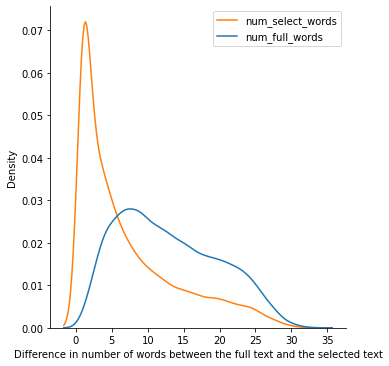

In [13]:
plt4 = sns.displot(train_data[['num_full_words','num_select_words']],kind='kde', legend = False)
plt.legend(["num_select_words", "num_full_words"])
plt.xlabel('Difference in number of words between the full text and the selected text')
plt.show()

## Word distribution of the full text and the selected text


### data cleaning and removal of stop words

In [14]:
def clean_text(text):
  '''This function renders texts lowercase, removes texts in square brackets, removes links,removes punctuation
  and removes words containing numbers.'''
  text = str(text).lower()
  text = re.sub('\[.*?\]', '', text)
  text = re.sub('https?://\S+|www\.\S+', '', text)
  text = re.sub('<.*?>+', '', text)
  text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
  text = re.sub('\n', '', text)
  text = re.sub('\w*\d\w*', '', text)
  return text

In [15]:
# Remove stop words
nltk.download('stopwords')
nltk.download('punkt')
stopwords = set(stopwords.words('english'))
stopwords.add("im")
stopwords.add("u")
def remove_stopwords(content):
  """ 
  This function removes the pre-defined stopwords

  """
  tokens = nltk.word_tokenize(content)
  tokens =[x for x in tokens if x not in stopwords]
  tokens = ' '.join(tokens)
  return tokens

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [16]:
train_data['text'] = train_data['text'].apply(lambda x : clean_text(x))
train_data['selected_text'] = train_data['selected_text'].apply(lambda x : clean_text(x))
test_data['text'] = test_data['text'].apply(lambda x : clean_text(x))

### Top 20 most frequently appearing words

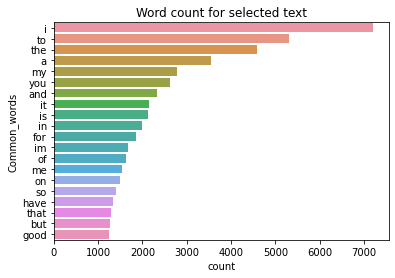

In [17]:
train_data['split_words'] = train_data['selected_text'].apply(lambda x : str(x).split())
top = Counter([item for sublist in train_data['split_words'] for item in sublist])
top = pd.DataFrame(top.most_common(20),columns=['Common_words','count'])
sns.barplot(data=top,x='count',y='Common_words')
plt.title("Word count for selected text")
plt.show()

#### Top 20 most frequently appearing words in positive texts

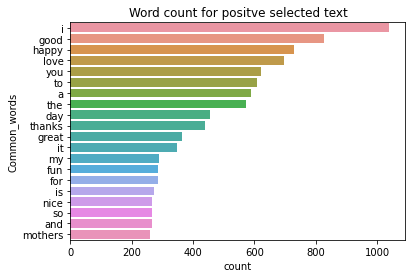

In [18]:
pos = train_data[train_data['sentiment']=='positive']
neg = train_data[train_data['sentiment']=='negative']
neu = train_data[train_data['sentiment']=='neutral']
top = Counter([item for sublist in pos['split_words'] for item in sublist])
top = pd.DataFrame(top.most_common(20),columns=['Common_words','count'])
sns.barplot(data=top,x='count',y='Common_words')
plt.title("Word count for positve selected text")
plt.show()

#### Top 20 most frequently appearing words in negative texts

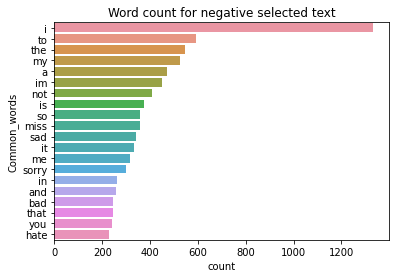

In [19]:
top = Counter([item for sublist in neg['split_words'] for item in sublist])
top = pd.DataFrame(top.most_common(20),columns=['Common_words','count'])
sns.barplot(data=top,x='count',y='Common_words')
plt.title("Word count for negative selected text")
plt.show()

#### Top 20 most frequently appearing words in neutral texts

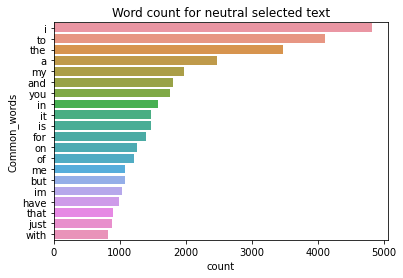

In [20]:
top = Counter([item for sublist in neu['split_words'] for item in sublist])
top = pd.DataFrame(top.most_common(20),columns=['Common_words','count'])
sns.barplot(data=top,x='count',y='Common_words')
plt.title("Word count for neutral selected text")
plt.show()

### Word cloud for selected texts

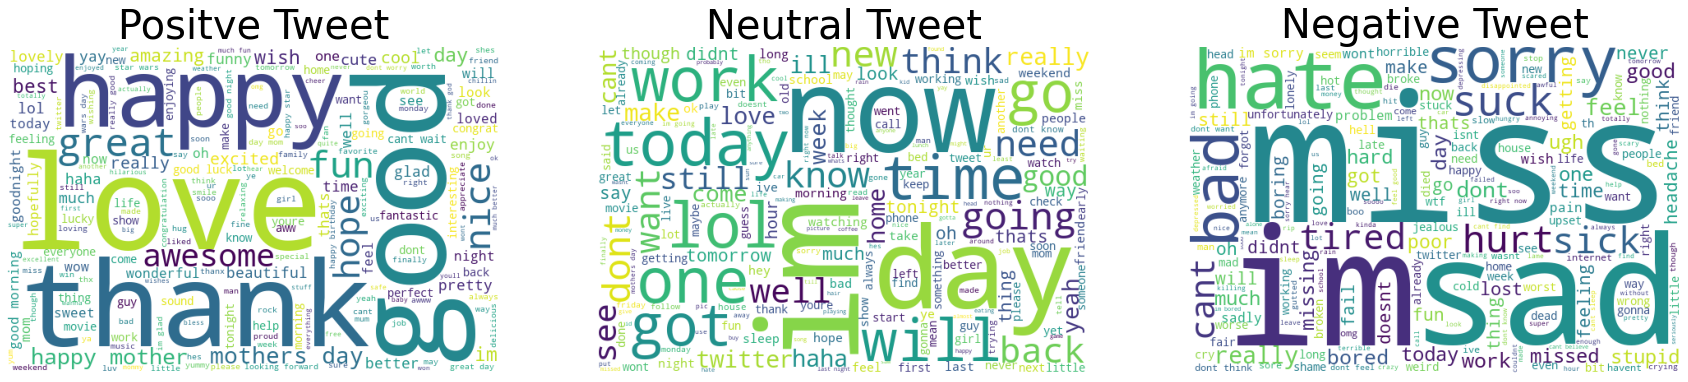

In [21]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[30, 15])
wordc1 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(pos.selected_text))
ax1.imshow(wordc1)
ax1.axis('off')
ax1.set_title('Positve Tweet', fontsize = 40)

wordc2 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(neu.selected_text))
ax2.imshow(wordc2)
ax2.axis('off')
ax2.set_title('Neutral Tweet', fontsize = 40)

wordc3 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(neg.selected_text))
ax3.imshow(wordc3)
ax3.axis('off')
ax3.set_title('Negative Tweet', fontsize = 40)
plt.show()

### Word cloud for full texts

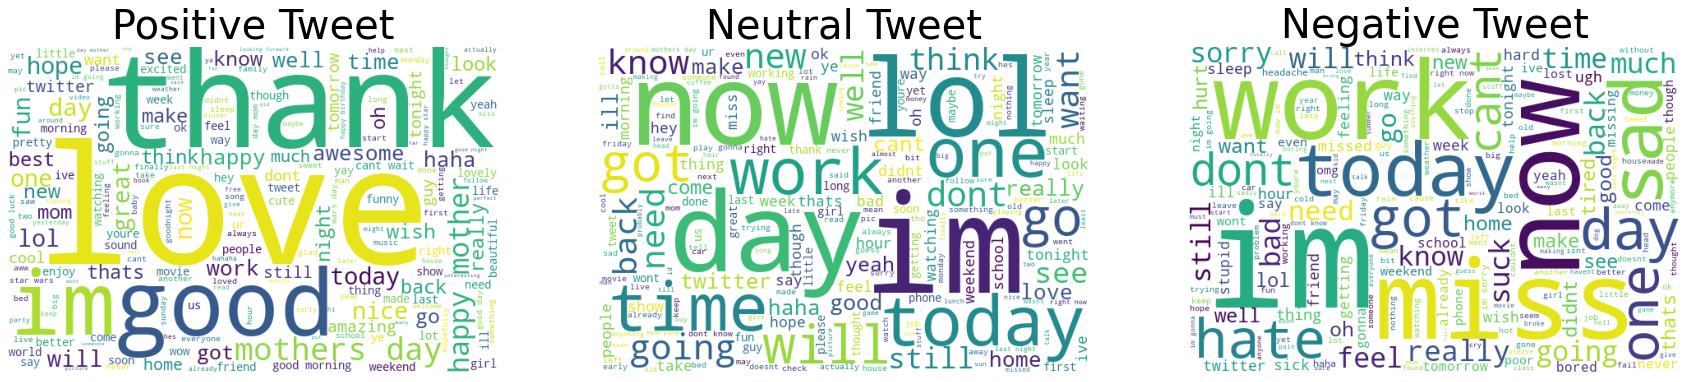

In [22]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[30, 15])
wordc1 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(pos.text))
ax1.imshow(wordc1)
ax1.axis('off')
ax1.set_title('Positive Tweet', fontsize = 40)

wordc2 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(neu.text))
ax2.imshow(wordc2)
ax2.axis('off')
ax2.set_title('Neutral Tweet', fontsize = 40)

wordc3 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(neg.text))
ax3.imshow(wordc3)
ax3.axis('off')
ax3.set_title('Negative Tweet', fontsize = 40)
plt.show()

# Word Embedding

## word2vec

### preprocessing

In [23]:
le = skl.preprocessing.LabelEncoder()
labels = le.fit_transform(train_data['sentiment'])
train_data['labels'] = labels
test_label = le.transform(test_data['sentiment'])
test_data['labels'] = test_label
train_df = train_data[['text','labels']]
test_df = test_data[['text','labels']]

In [24]:
train_df = train_df[train_df['labels']!=1]
test_df = test_df[test_df['labels']!= 1]
train_df['labels'] = train_df['labels'].apply(lambda x: 1 if x==2 else x)
test_df['labels'] = test_df['labels'].apply(lambda x: 1 if x==2 else x)
train_list = list(train_df['text'].values)
test_list = list(test_df['text'].values)
train_labels = list(train_df['labels'].values)
test_labels = list(test_df['labels'].values)

### build word2vec model

In [25]:
# download twitter corpus
twitter_corpus = api.load('glove-twitter-200')

[=================================================-] 100.0% 758.3/758.5MB downloaded


In [26]:
# train dataset
vocab = list(twitter_corpus.wv.vocab.keys())
word2vec = []
abandoned = []
train_labels_new = []
for i,doc in tqdm(enumerate(train_list)):
  if len(doc) > 0: # in case there is an empty string
    words = doc.split()
    count = 0
    vec = np.zeros(200)
    for w in words:
      if w in vocab:
        count+=1
        vec += twitter_corpus.wv[w]
      else:
        abandoned.append(w)
    if count > 0:
      vec/=count
      word2vec.append(vec)
      train_labels_new.append(train_labels[i])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  
0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  
16363it [03:03, 89.39it/s]


In [27]:
# test dataset
word2vec_test = []
abandoned_test = []
test_labels_new = []
for i,doc in tqdm(enumerate(test_list)):
  if len(doc) > 0: # in case there is an empty string
    words = doc.split()
    count = 0
    vec = np.zeros(200)
    for w in words:
      if w in vocab:
        count+=1
        vec += twitter_corpus.wv[w]
      else:
        abandoned_test.append(w)
    if count > 0:
      vec/=count
      word2vec_test.append(vec)
      test_labels_new.append(test_labels[i])


0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  del sys.path[0]
2104it [00:23, 90.34it/s]


##BERT

### multiclass classification

In [28]:
train_df_multi = train_data[['text','labels']]
test_df_multi = test_data[['text','labels']]

downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


Is Multi-Label? False
maxlen is 140
done.


begin training using onecycle policy with max lr of 2e-05...
Epoch 1/3
859/859 [==============================] - 714s 804ms/step - loss: 0.8599 - accuracy: 0.5757 - val_loss: 0.5601 - val_accuracy: 0.7753
Epoch 2/3
859/859 [==============================] - 685s 798ms/step - loss: 0.4972 - accuracy: 0.7965 - val_loss: 0.5228 - val_accuracy: 0.7835
Epoch 3/3
859/859 [==============================] - 686s 798ms/step - loss: 0.3504 - accuracy: 0.8676 - val_loss: 0.5676 - val_accuracy: 0.7818


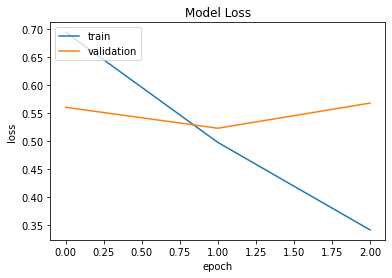

In [29]:
(X_train,y_train),(X_test,y_test),preprocess = text.texts_from_df(train_df = train_df_multi,
                   text_column = 'text',
                   label_columns = 'labels',
                   val_df = test_df_multi,
                   maxlen = 140,
                   preprocess_mode = 'bert')
# build Bert model
model = text.text_classifier(name='bert',train_data=(X_train,y_train),preproc = preprocess)
learner = ktrain.get_learner(model = model, train_data =(X_train,y_train),
                                val_data = (X_test,y_test), 
                                batch_size = 32)
# train the model
learner.fit_onecycle(lr=2e-5,epochs=3)
learner.plot(plot_type='loss')

In [30]:
# evaluate the accuracy of the model
predictor = ktrain.get_predictor(learner.model,preprocess)
true_labels = test_df_multi['labels']
lst = []
lst_of_labels = []
for tweet in tqdm(list(test_df_multi['text'].values)):
  prediction = int(predictor.predict(tweet)[-1])
  lst_of_labels.append(prediction)

acc = 0
total = 0
for indx,label in enumerate(true_labels):
  total+=1
  if label == lst_of_labels[indx]:
    acc+=1
print('Accuracy for validation dataset is: ', acc/total)

100%|██████████| 3534/3534 [04:29<00:00, 13.09it/s]

Accuracy for validation dataset is:  0.7818336162988115


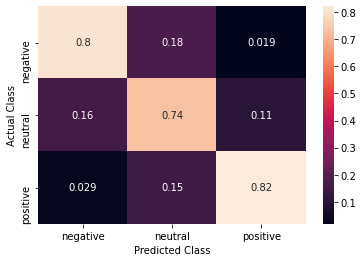

In [31]:
# confusion matrix
classes = ['negative','neutral','positive']
final_array = sklearn.metrics.confusion_matrix(true_labels.values, np.array(lst_of_labels))
final_array = pd.DataFrame(final_array, index= classes,columns= classes)
final_array = final_array.apply(lambda x :x/final_array.sum(axis=1))
plt_bert_test = sns.heatmap(final_array, annot=True)
plt_bert_test.set_xlabel('Predicted Class')
plt_bert_test.set_ylabel('Actual Class')
plt.show()

**BERT Model Walk-through:**

BERT is a deep neural network model that takes training samples as inputs and outputs the predicted classes for classification  problem. The inputs for BERT are embedded dynamically, which means  BERT produces word representations that are dynamically informed by the words around them.  That is a polysemy word can have different embeddings depending on its context.

Here, we use BERT model to do binary classification and multiclass classification. The hyperparameters that are tuned for the model is learning rate, batch size, and epochs.

Using ktrain api under Keras library, we can do a grid-search on finding the best learning rate suited for the model. However, this process could take days to complete. Therefore, we chose to use a learning rate of 2e-5 which generally performs well according to the original paper of BERT. 

The way that the batch size is chosen is correlated to the max length of the dataset, i.e., the max number of words in a tweet. The larger the max length, the smaller the batch size we should use in order to prevent out-of-memory issue. For max length around 150, batch size of 32 can be used. If batch size exceeds 64, out-of-memory issue would occur. Large max length of tweets and large batch size can both incur out-of-memory issue. 

Three epochs chosen here is good enough for the model to yield a relatively high test accuracy. As epoch increases, the training and test accuracy increases slowly. As shown in the visualization of the loss curve above, as epoch increases, the training loss decreases. The validation loss also decreases but with slight fluctuation on the third epoch.

The final performance of BERT model is the best among other models used in this project. The overall accuracy on test dataset for binary classification is 0.9373, and 0.7847 for multiclass classification. For binary case, the accuracy of predicting positive tweets is 0.92 and that of predicting negative tweets is 0.95. For multiclass case, the accuracy of predicting positive tweets is 0.83, that of predicting neutral tweets is 0.77, and that of predicting negative tweets is 0.77.





### binary classification

In [32]:
# data preprocessing
train_data = train_data[train_data['sentiment']!='neutral']
test_data = test_data[test_data['sentiment']!= 'neutral']

features = train_data['text']
train_data['labels'] = train_data['labels'].apply(lambda x: 1 if x==2 else x)
labels = train_data['labels']

features_test = test_data['text']
test_data['labels'] = test_data['labels'].apply(lambda x: 1 if x==2 else x)
labels_test = test_data['labels']

train_df_binary = pd.DataFrame({'text':features,'labels':labels})
test_df_binary = pd.DataFrame({'text':features_test,'labels':labels_test})

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


Is Multi-Label? False
maxlen is 140
done.


begin training using onecycle policy with max lr of 2e-05...
Epoch 1/3
512/512 [==============================] - 439s 811ms/step - loss: 0.4344 - accuracy: 0.7820 - val_loss: 0.1766 - val_accuracy: 0.9339
Epoch 2/3
512/512 [==============================] - 411s 803ms/step - loss: 0.1598 - accuracy: 0.9435 - val_loss: 0.1774 - val_accuracy: 0.9330
Epoch 3/3
512/512 [==============================] - 410s 801ms/step - loss: 0.0826 - accuracy: 0.9758 - val_loss: 0.2058 - val_accuracy: 0.9377


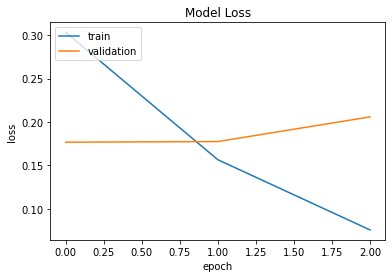

In [33]:
(X_train_bi,y_train_bi),(X_test_bi,y_test_bi),preprocess_bi = text.texts_from_df(train_df = train_df_binary,
                   text_column = 'text',
                   label_columns = 'labels',
                   val_df = test_df_binary,
                   maxlen = 140,
                   preprocess_mode = 'bert')
# build the model
model_bi = text.text_classifier(name='bert',train_data=(X_train_bi,y_train_bi),preproc = preprocess_bi)
learner_bi = ktrain.get_learner(model = model_bi, train_data =(X_train_bi,y_train_bi),
                                val_data = (X_test_bi,y_test_bi), 
                                batch_size = 32)
# train the model
learner_bi.fit_onecycle(lr=2e-5,epochs=3)
learner_bi.plot(plot_type='loss')

In [34]:
# evaluate the accuracy of the model
predictor = ktrain.get_predictor(learner_bi.model,preprocess_bi)
true_labels = test_df_binary['labels']
lst_of_labels = []
for tweet in tqdm(list(test_df_binary['text'].values)):
  prediction = predictor.predict(tweet)
  if prediction == 'labels':
    lst_of_labels.append(1)
  else:
    lst_of_labels.append(0)

acc = 0
total = 0
for indx,label in enumerate(true_labels):
  total+=1
  if label == lst_of_labels[indx]:
    acc+=1
print('Accuracy for validation dataset is: ', acc/total)

100%|██████████| 2104/2104 [02:44<00:00, 12.80it/s]

Accuracy for validation dataset is:  0.9377376425855514


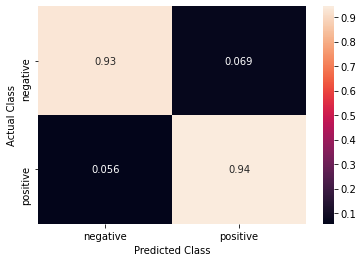

In [35]:
# confusion matrix
classes = ['negative','positive']
final_array = sklearn.metrics.confusion_matrix(true_labels.values, np.array(lst_of_labels))
final_array = pd.DataFrame(final_array, index= classes,columns= classes)
final_array = final_array.apply(lambda x :x/final_array.sum(axis=1))
plt_bert_test = sns.heatmap(final_array, annot=True)
plt_bert_test.set_xlabel('Predicted Class')
plt_bert_test.set_ylabel('Actual Class')
plt.show()

## Word Count 

In [36]:
# Remove the neutral tag
train_data = train_data[train_data['sentiment']!='neutral']
test_data = test_data[test_data['sentiment']!= 'neutral']

In [37]:
#Word count
vectorizer = sklearn.feature_extraction.text.CountVectorizer(stop_words='english')
le = sklearn.preprocessing.LabelEncoder()
labels = le.fit_transform(train_data['sentiment'])
features = vectorizer.fit(train_data['text']).transform(train_data['selected_text'])
test_features = vectorizer.transform(test_data['text'])
test_labels = le.transform(test_data['sentiment'])

## TF-IDF

In [38]:
# Remove the neutral tag
train_data = train_data[train_data['sentiment']!='neutral']
test_data = test_data[test_data['sentiment']!= 'neutral']

In [39]:
#TF-IDF features
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(analyzer='char_wb',ngram_range=(4,4),stop_words='english')
features = vectorizer.fit_transform(train_data['text'])
le = sklearn.preprocessing.LabelEncoder()
labels = le.fit_transform(train_data['sentiment'])
test_features = vectorizer.transform(test_data['text'])
test_labels = le.transform(test_data['sentiment'])

#Naive Bayes

In [45]:
# train data
clf = MultinomialNB(fit_prior=False)
clf.fit(features,labels)
clf.score(features,labels)
# test data
test_data = test_data.dropna()
test_features = vectorizer.transform(test_data['text'])
test_labels = le.transform(test_data['sentiment'])
clf.score(test_features,test_labels)
pred = clf.predict(test_features)

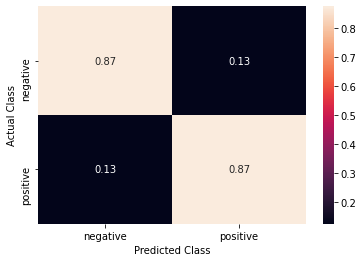

In [46]:
# test data confusion matrix
final_array = skl.metrics.confusion_matrix(test_labels, pred)
final_array = pd.DataFrame(final_array, index=le.classes_,columns=le.classes_)
final_array = final_array.apply(lambda x :x/final_array.sum(axis=1))
plt_nb = sns.heatmap(final_array, annot=True)
plt_nb.set_xlabel('Predicted Class')
plt_nb.set_ylabel('Actual Class')
plt.show()

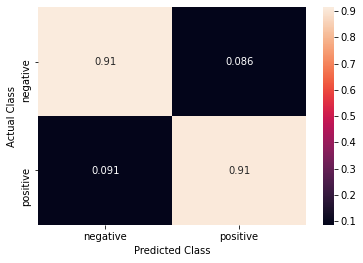

In [48]:
# train data confusion matrix
pred_nb_train = clf.predict(features)
final_array = sklearn.metrics.confusion_matrix(labels, pred_nb_train)
final_array = pd.DataFrame(final_array, index=le.classes_,columns=le.classes_)
final_array = final_array.apply(lambda x :x/final_array.sum(axis=1))
plt_nb_train = sns.heatmap(final_array, annot=True)
plt_nb_train.set_xlabel('Predicted Class')
plt_nb_train.set_ylabel('Actual Class')
plt.show()

#Random Forest

In [49]:
clf2 = RandomForestClassifier(n_jobs=-1, random_state= 12, n_estimators=120, verbose=1)
clf2.fit(features,labels)
clf2.score(features,labels)
clf2.estimator_params
clf2.score(test_features,test_labels) 
pred_rf = clf2.predict(test_features)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   18.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 120 out of 120 | elapsed:    1.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 120 out of 120 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 120 out of 120 | elapsed:    0.2s finished


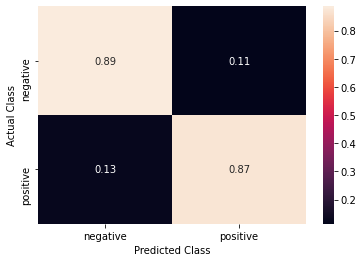

In [51]:
# test data confusion matrix
final_array = sklearn.metrics.confusion_matrix(test_labels, pred_rf)
final_array = pd.DataFrame(final_array, index=le.classes_,columns=le.classes_)
final_array = final_array.apply(lambda x :x/final_array.sum(axis=1))
plt_rf = sns.heatmap(final_array, annot=True)
plt_rf.set_xlabel('Predicted Class')
plt_rf.set_ylabel('Actual Class')
plt.show()

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 120 out of 120 | elapsed:    1.0s finished


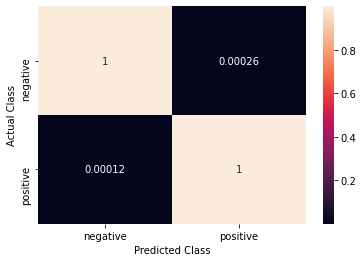

In [52]:
# train data confusion matrix
pred_rf_train = clf2.predict(features)
final_array = sklearn.metrics.confusion_matrix(labels, pred_rf_train)
final_array = pd.DataFrame(final_array, index=le.classes_,columns=le.classes_)
final_array = final_array.apply(lambda x :x/final_array.sum(axis=1))
plt_rf_train = sns.heatmap(final_array, annot=True)
plt_rf_train.set_xlabel('Predicted Class')
plt_rf_train.set_ylabel('Actual Class')
plt.show()

#Logistic Regression

In [53]:
clf3 = LogisticRegression(random_state=12,max_iter=1000,n_jobs = -1,verbose=1,l1_ratio=0.9,penalty='elasticnet',solver='saga')
clf3.fit(features,labels)
clf3.score(features,labels)
clf3.score(test_features,test_labels)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


convergence after 52 epochs took 6 seconds


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    6.0s finished


0.8830798479087453

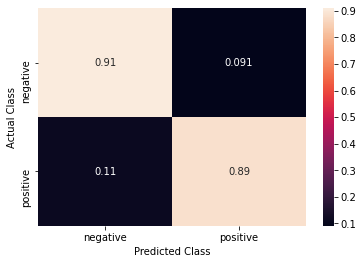

In [54]:
# test data confusion matrix
pred_lr_train = clf3.predict(features)
final_array = sklearn.metrics.confusion_matrix(labels, pred_lr_train)
final_array = pd.DataFrame(final_array, index=le.classes_,columns=le.classes_)
final_array = final_array.apply(lambda x :x/final_array.sum(axis=1))
plt_lr_train = sns.heatmap(final_array, annot=True)
plt_lr_train.set_xlabel('Predicted Class')
plt_lr_train.set_ylabel('Actual Class')
plt.show()

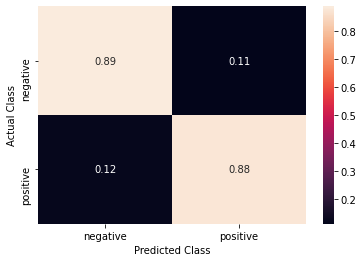

In [55]:
# train data confusion matrix
pred_lr = clf3.predict(test_features)
final_array = sklearn.metrics.confusion_matrix(test_labels, pred_lr)
final_array = pd.DataFrame(final_array, index=le.classes_,columns=le.classes_)
final_array = final_array.apply(lambda x :x/final_array.sum(axis=1))
plt_rf_test = sns.heatmap(final_array, annot=True)
plt_rf_test.set_xlabel('Predicted Class')
plt_rf_test.set_ylabel('Actual Class')
plt.show()

#SVM

In [56]:
clf4 = SVC(C=1.0,verbose=1,kernel='rbf')
clf4.fit(features,labels)
clf4_2 = LinearSVC(penalty='l1',dual=False)
clf4_2.fit(features,labels)
clf4.score(features,labels)
clf4.score(test_features,test_labels)
clf4_2.score(features,labels)
clf4_2.score(test_features,test_labels)

[LibSVM]

0.8921102661596958

Text(33.0, 0.5, 'Actual Class')

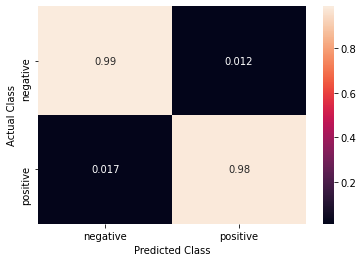

In [57]:
# train data confusion matrix - SVM with RBF kernel
pred_svm_train = clf4.predict(features)
final_array = sklearn.metrics.confusion_matrix(labels, pred_svm_train)
final_array = pd.DataFrame(final_array, index=le.classes_,columns=le.classes_)
final_array = final_array.apply(lambda x :x/final_array.sum(axis=1))
plt_svm_train = sns.heatmap(final_array, annot=True)
plt_svm_train.set_xlabel('Predicted Class')
plt_svm_train.set_ylabel('Actual Class')

Text(33.0, 0.5, 'Actual Class')

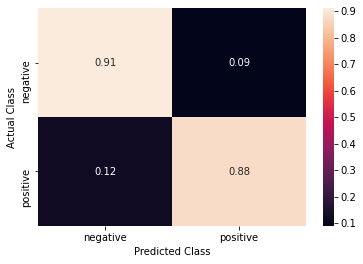

In [58]:
# test data confusion matrix - SVM with RBF kernel
pred_svm = clf4.predict(test_features)
final_array = sklearn.metrics.confusion_matrix(test_labels, pred_svm)
final_array = pd.DataFrame(final_array, index=le.classes_,columns=le.classes_)
final_array = final_array.apply(lambda x :x/final_array.sum(axis=1))
plt_svm_test = sns.heatmap(final_array, annot=True)
plt_svm_test.set_xlabel('Predicted Class')
plt_svm_test.set_ylabel('Actual Class')

Text(33.0, 0.5, 'Actual Class')

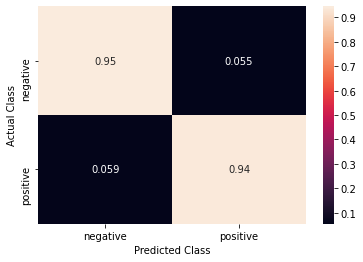

In [59]:
# train data confusion matrix - SVM with linear kernel
pred_svm_train = clf4_2.predict(features)
final_array = sklearn.metrics.confusion_matrix(labels, pred_svm_train)
final_array = pd.DataFrame(final_array, index=le.classes_,columns=le.classes_)
final_array = final_array.apply(lambda x :x/final_array.sum(axis=1))
plt_svm_train = sns.heatmap(final_array, annot=True)
plt_svm_train.set_xlabel('Predicted Class')
plt_svm_train.set_ylabel('Actual Class')

Text(33.0, 0.5, 'Actual Class')

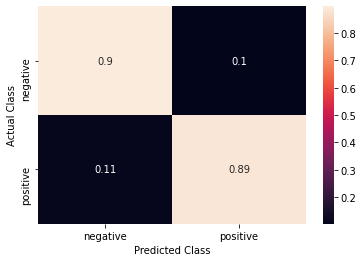

In [60]:
# test data confusion matrix - SVM with linear kernel
pred_svm = clf4_2.predict(test_features)
final_array = sklearn.metrics.confusion_matrix(test_labels, pred_svm)
final_array = pd.DataFrame(final_array, index=le.classes_,columns=le.classes_)
final_array = final_array.apply(lambda x :x/final_array.sum(axis=1))
plt_svm_test = sns.heatmap(final_array, annot=True)
plt_svm_test.set_xlabel('Predicted Class')
plt_svm_test.set_ylabel('Actual Class')

# Neural Network
In this section we used Multilayer Perceptron, in other words, fully connected neural network to train the data.

For the TF-IDF embedding, since it generates more features than fasttext, it is easy to get overfit, the best result appears at 1 hidden layer with 4 nodes, the training score is 0.965 and the test score is 0.884. We found that training score is higher than logistic regression but test score decreases. So for this data set, Neural Net is so easy to get overfitting that cannot improve our model for sentiment analysis.


In [61]:
from sklearn.neural_network import MLPClassifier
clf5 = MLPClassifier(verbose=1)

First we do a Gridsearch to find the best hyperparameters, in 

```
GridSearchCV()
```
we tried 3 different activation function: Sigmoid, ReLU and No activation(Identity)

3 different structure of hidden layer (4), (8,2), (32,16,4)


In [62]:
from sklearn.model_selection import GridSearchCV
para = {'activation': ['logistic','relu','identity'], 'hidden_layer_sizes':[(4),(8,2),(32,16,4)],'max_iter':[50] }
cv = GridSearchCV(clf5, para, n_jobs = -1, cv = 3, verbose=1)
cv.fit(features, labels)
print(cv.best_estimator_)
cv.best_estimator_.fit(features, labels).fit(features, labels)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed: 10.0min finished


Iteration 1, loss = 0.68843474
Iteration 2, loss = 0.67823427
Iteration 3, loss = 0.66447603
Iteration 4, loss = 0.64547788
Iteration 5, loss = 0.62115211
Iteration 6, loss = 0.59277414
Iteration 7, loss = 0.56216741
Iteration 8, loss = 0.53108177
Iteration 9, loss = 0.50072226
Iteration 10, loss = 0.47203830
Iteration 11, loss = 0.44537918
Iteration 12, loss = 0.42079382
Iteration 13, loss = 0.39841560
Iteration 14, loss = 0.37805446
Iteration 15, loss = 0.35941452
Iteration 16, loss = 0.34248391
Iteration 17, loss = 0.32707320
Iteration 18, loss = 0.31294551
Iteration 19, loss = 0.30001879
Iteration 20, loss = 0.28815658
Iteration 21, loss = 0.27722816
Iteration 22, loss = 0.26710839
Iteration 23, loss = 0.25772353
Iteration 24, loss = 0.24906130
Iteration 25, loss = 0.24093487
Iteration 26, loss = 0.23339616
Iteration 27, loss = 0.22633539
Iteration 28, loss = 0.21971001
Iteration 29, loss = 0.21350952
Iteration 30, loss = 0.20767540
Iteration 31, loss = 0.20217471
Iteration 32, los

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.68967607
Iteration 2, loss = 0.68347615
Iteration 3, loss = 0.67488463
Iteration 4, loss = 0.66233525
Iteration 5, loss = 0.64503431
Iteration 6, loss = 0.62337496
Iteration 7, loss = 0.59864355
Iteration 8, loss = 0.57236165
Iteration 9, loss = 0.54587393
Iteration 10, loss = 0.52001152
Iteration 11, loss = 0.49534582
Iteration 12, loss = 0.47206706
Iteration 13, loss = 0.45036428
Iteration 14, loss = 0.43020356
Iteration 15, loss = 0.41146021
Iteration 16, loss = 0.39413338
Iteration 17, loss = 0.37811311
Iteration 18, loss = 0.36325311
Iteration 19, loss = 0.34946116
Iteration 20, loss = 0.33665314
Iteration 21, loss = 0.32472598
Iteration 22, loss = 0.31358349
Iteration 23, loss = 0.30320587
Iteration 24, loss = 0.29347342
Iteration 25, loss = 0.28438900
Iteration 26, loss = 0.27582504
Iteration 27, loss = 0.26780060
Iteration 28, loss = 0.26020209
Iteration 29, loss = 0.25307461
Iteration 30, loss = 0.24628387
Iteration 31, loss = 0.23989085
Iteration 32, los

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.72001284
Iteration 2, loss = 0.68470776
Iteration 3, loss = 0.66457694
Iteration 4, loss = 0.64772763
Iteration 5, loss = 0.62922981
Iteration 6, loss = 0.60754610
Iteration 7, loss = 0.58285377
Iteration 8, loss = 0.55600406
Iteration 9, loss = 0.52809963
Iteration 10, loss = 0.50019555
Iteration 11, loss = 0.47312861
Iteration 12, loss = 0.44742941
Iteration 13, loss = 0.42341809
Iteration 14, loss = 0.40116544
Iteration 15, loss = 0.38074107
Iteration 16, loss = 0.36199417
Iteration 17, loss = 0.34486974
Iteration 18, loss = 0.32919438
Iteration 19, loss = 0.31479671
Iteration 20, loss = 0.30162839
Iteration 21, loss = 0.28948668
Iteration 22, loss = 0.27832599
Iteration 23, loss = 0.26799209
Iteration 24, loss = 0.25844348
Iteration 25, loss = 0.24958880
Iteration 26, loss = 0.24132711
Iteration 27, loss = 0.23362740
Iteration 28, loss = 0.22647199
Iteration 29, loss = 0.21972503
Iteration 30, loss = 0.21339425
Iteration 31, loss = 0.20748715
Iteration 32, los

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='logistic', hidden_layer_sizes=4, max_iter=50,
              verbose=1)

And now we find out the best estimator is the 1-layer 4 nodes Neural Net with Sigmoid activation function 

Training Score

In [64]:
cv.score(features, labels)

0.9672431705677443

Test Score

In [65]:
cv.score(test_features, test_labels)

0.8849809885931559

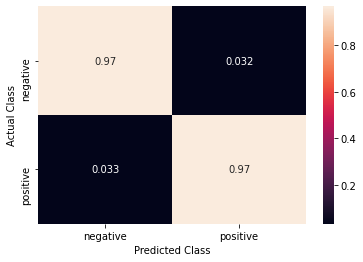

In [69]:
# train data confusion matrix
pred_nn = cv.predict(features)
final_array = sklearn.metrics.confusion_matrix(labels, pred_nn)
final_array = pd.DataFrame(final_array, index=le.classes_,columns=le.classes_)
final_array = final_array.apply(lambda x :x/final_array.sum(axis=1))
plt_svm_test = sns.heatmap(final_array, annot=True)
plt_svm_test.set_xlabel('Predicted Class')
plt_svm_test.set_ylabel('Actual Class')
plt.show()

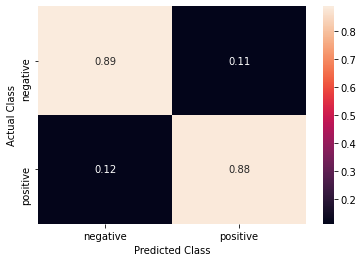

In [70]:
# test data confusion matrix
pred_nn = cv.predict(test_features)
final_array = sklearn.metrics.confusion_matrix(test_labels, pred_nn)
final_array = pd.DataFrame(final_array, index=le.classes_,columns=le.classes_)
final_array = final_array.apply(lambda x :x/final_array.sum(axis=1))
plt_svm_test = sns.heatmap(final_array, annot=True)
plt_svm_test.set_xlabel('Predicted Class')
plt_svm_test.set_ylabel('Actual Class')
plt.show()